# Part 1: Build the model in TensorFlow 1

In [2]:
from __future__ import print_function
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import sys
import urllib.request
import zipfile
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
model_pb_dir='./model_pb/'
os.makedirs(model_pb_dir) if not os.path.exists(model_pb_dir) else None    

model_url='https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'
model_path='./model_pb/inception5h.zip'
model_dir='./model_pb/inception5h/'

if not os.path.exists(model_dir):
    if not os.path.isfile(model_path):
        result=urllib.request.urlretrieve(model_url,model_path)
        print('pre-trained model does not exist, downloading it now:',result)
        with zipfile.ZipFile(model_path,"r") as zip_ref:
            zip_ref.extractall(model_dir)
        print('model zip has not been extracted, extracting it now...')
        os.remove(model_path)
    else: 
        print(model_path,'pre-trained model zip found!')
        with zipfile.ZipFile(model_path,"r") as zip_ref:
            zip_ref.extractall(model_dir)
        print('model zip has not been extracted, extracting it now...')
        os.remove(model_path)
else:
    print('extracted model been found!')

extracted model been found!


In [4]:
def resize_image(image,height_and_width):
    min=image.min()
    max=image.max()
    image=(image-min)/(max-min)*255
    image=Image.fromarray(np.uint8(image)).resize((height_and_width[1],height_and_width[0]))
    image=np.array(image).astype(np.float32)
    image=image/255*(max-min)+min
    return image

def calc_grad_tiled(image,t_grad,tile_size=512):
    sz=tile_size
    height,width=image.shape[:2]
    sx,sy=np.random.randint(sz,size=2)
    image_shift=np.roll(np.roll(image,sx,1),sy,0)
    grad=np.zeros_like(image)
    for y in range(0,max(height-sz//2,sz),sz):
        for x in range(0,max(width-sz//2,sz),sz):
            sub=image_shift[y:y+sz,x:x+sz]
            grad[y:y+sz,x:x+sz]=sess.run(t_grad,{t_input:sub})
    return np.roll(np.roll(grad,-sx,1),-sy,0)

def render_deepdream(t_obj,image0,iter_n=100,step=1.0,octave_n=4,octave_scale=1.4):
    t_grad=tf.gradients(tf.reduce_mean(t_obj),t_input)[0]
    image=image0.copy()
    octaves=[]
    for i in range(octave_n-1):
        heigth_and_width=image.shape[:2]
        low_freq=resize_image(image,np.int32(np.float32(heigth_and_width)/octave_scale))
        high_freq=image-resize_image(low_freq,heigth_and_width)
        image=low_freq
        octaves.append(high_freq)
    for i in range(octave_n):
        if i>0:
            high_freq=octaves[-i]
            image=resize_image(image,high_freq.shape[:2])+high_freq
        for i in range(iter_n):
            g=calc_grad_tiled(image,t_grad)
            image+=g*(step/(np.abs(g).mean()+1e-7))
    image=image.clip(0,255)
    Image.fromarray(np.uint8(image)).save('./datasets/mountain_deepdream.jpg')
    Image.open("./datasets/mountain_deepdream.jpg").show()

In [5]:
graph=tf.Graph()
sess=tf.InteractiveSession(graph=graph)

model_pb_path='./model_pb/inception5h/tensorflow_inception_graph.pb'
with tf.gfile.GFile(model_pb_path,'rb') as pb:
    graph_def=tf.GraphDef()
    graph_def.ParseFromString(pb.read())

t_input=tf.placeholder(np.float32,name='input')
t_preprocessed=tf.expand_dims(t_input-117.0,0)
tf.import_graph_def(graph_def,{'input':t_preprocessed})

CNN_layer='mixed4c'
layer_output=graph.get_tensor_by_name('import/%s:0'%CNN_layer)
image0=np.float32(Image.open('./datasets/mountain.jpg'))
render_deepdream(tf.square(layer_output),image0)

# Part 2: Build the same model but in TensorFlow 2

In [6]:
sys.exit("The previous part of code finished execution. To run the following code, please 'Restart' and 'Run All' manually.")

SystemExit: The previous part of code finished execution. To run the following code, please 'Restart' and 'Run All' manually.

In [1]:
import tensorflow as tf
import tensorflow.keras.preprocessing.image as preprocess_image
import numpy as np
import IPython.display as display
import PIL.Image 
from time import time

print('Tensorflow version:',tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def normalize_image(image):
    image=255*(image+1.0)/2.0
    return tf.cast(image,tf.uint8)
def show_image(image):
    display.display(PIL.Image.fromarray(np.array(image)))
def save_image(image,image_path):
    PIL.Image.fromarray(np.uint8(image)).save(image_path)
def cal_loss(image,model):
    image=tf.expand_dims(image,0)
    layer_activations=model(image)
    losses=[]
    for i in layer_activations:
        loss=tf.math.reduce_mean(i)
        losses.append(loss)
    return tf.reduce_sum(losses)
def render_deepdream(model,image,steps=100,step_size=0.01,verbose=1):
    for step in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss=cal_loss(image,model)
        gradients=tape.gradient(loss,image)
        gradients/=tf.math.reduce_std(gradients)+1e-8
        image=image+gradients*step_size
        image=tf.clip_by_value(image,-1,1)
        if(verbose==1)&((step+1)%10==0):
            print('step{}/{},loss{}'.format(step+1,steps,loss))
    return image

In [3]:
base_model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
CNN_layer_name=['mixed3','mixed5']
CNN_layer_output=[base_model.get_layer(layer).output for layer in CNN_layer_name]
dream_model=tf.keras.Model(inputs=base_model.input,outputs=CNN_layer_output)

Generating a background image with random noise then use it for deepdream training

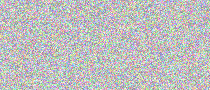

In [4]:
image_noise=np.random.uniform(size=(90,210,3))
image_noise=image_noise.astype(np.float32)
show_image(normalize_image(image_noise))
image=tf.keras.applications.inception_v3.preprocess_input(image_noise+100.0)
image=tf.convert_to_tensor(image)

step10/50,loss1.4666213989257812
step20/50,loss1.8474352359771729
step30/50,loss2.173961877822876
step40/50,loss2.4195303916931152
step50/50,loss2.5723161697387695


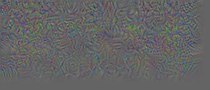

finish deepdream, takes:6.587290525436401


In [5]:
startTime=time()
dream_image=render_deepdream(dream_model,image,steps=50,step_size=0.01)
show_image(normalize_image(dream_image))

image_path='datasets/deepdream_{}.jpg'.format(CNN_layer_name)
save_image(dream_image,image_path)
print('finish deepdream, takes:{}'.format(time()-startTime))

Load an image, scale it to a range of sizes from small to large, then feed it into the model

In [6]:
def read_image(image_path='datasets/mountain.jpg',max_dim=None):
    image=PIL.Image.open(image_path)
    if max_dim: image.thumbnail((max_dim,max_dim))
    return np.array(image)

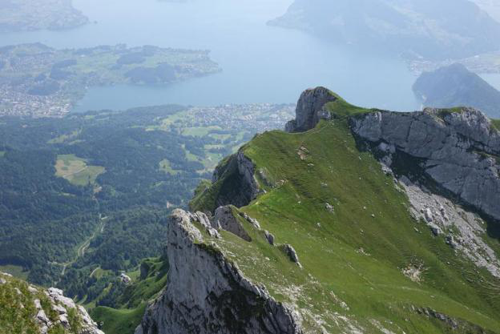

In [7]:
image=read_image(max_dim=500)
show_image(image)
image=tf.keras.applications.inception_v3.preprocess_input(image)
image=tf.convert_to_tensor(image)
initial_shape=tf.shape(image)[:-1]

step10/10,loss1.267159104347229
step10/10,loss1.2445430755615234
step10/10,loss1.210602045059204
step10/10,loss1.194039225578308
step10/10,loss1.158140778541565


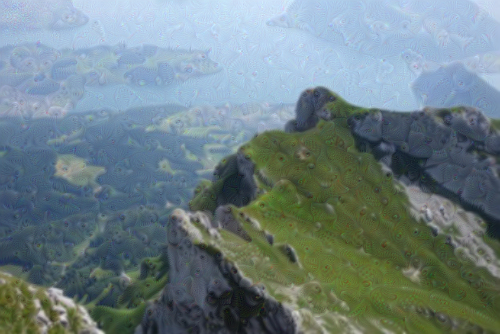

finish deepdream, takes:3.926910161972046


In [8]:
startTime=time()
octave_scale=1.30
for octave in range(-2,3):
    new_size=tf.cast(tf.convert_to_tensor(initial_shape),tf.float32)*(octave_scale**octave)
    image=tf.image.resize(image,tf.cast(new_size,tf.int32))
    dream_image=render_deepdream(dream_model,image,steps=10,step_size=0.01)
dream_image=tf.image.resize(dream_image,initial_shape)
show_image(normalize_image(dream_image))

image_path='datasets/deepdream_{}.jpg'.format(CNN_layer_name)
save_image(dream_image,image_path)
print('finish deepdream, takes:{}'.format(time()-startTime))

Going a step further than the previous one for the best result. The image is first rolled and then sliced into smaller pieces for training, in this case the result will be softer and more effective

In [9]:
def image_random_roll(image,max_roll_num=512):
    shift_down,shift_right=tf.random.uniform(shape=[2],minval=-max_roll_num,maxval=max_roll_num,dtype=tf.int32)
    image_rolled=tf.roll(tf.roll(image,shift_right,axis=1),shift_down,axis=0)
    return shift_down,shift_right,image_rolled
def get_tiled_gradients(model,image,tile_size=150):
    shift_down,shift_right,image_rolled=image_random_roll(image,tile_size)
    # initialize the gradients to 0
    gradients=tf.zeros_like(image_rolled)
    # get the axis list of where the image has been tiled
    x_axis_list=tf.range(0,image_rolled.shape[0],tile_size)
    y_axis_list=tf.range(0,image_rolled.shape[1],tile_size)
    for x in x_axis_list:
        for y in y_axis_list:
            # calculate the gradient of this tiled image
            with tf.GradientTape() as tape:
                tape.watch(image_rolled)
                # get the tiled image from the whole image
                image_tile=image_rolled[x:x+tile_size,y:y+tile_size]
                loss=cal_loss(image_tile,model)
                # upgrade the gradient of the whole image
                gradients=gradients+tape.gradient(loss,image_rolled)
    # place the tile back to it's original position
    gradients=tf.roll(tf.roll(gradients,-shift_right,axis=1),-shift_down,axis=0)
    gradients/=tf.math.reduce_std(gradients)+1e-8
    return gradients
def render_deepdream_with_octaves(model,image,step_per_octave=100,step_size=0.01,octaves=range(-2,3),octave_scale=1.3):
    initial_shape=image.shape[:-1]
    for octave in octaves:
        new_size=tf.cast(tf.convert_to_tensor(initial_shape),tf.float32)*(octave_scale**octave)
        image=tf.image.resize(image,tf.cast(new_size,tf.int32))
        for step in range(step_per_octave):
            gradients=get_tiled_gradients(model,image)
            image=image+gradients*step_size
            image=tf.clip_by_value(image,-1,1)
            if((step+1)%10==0):
                print('octave {},step {}'.format(octave,step+1))
    image=tf.image.resize(image,initial_shape)
    return normalize_image(image)

In [ ]:
startTime=time()
image=read_image(max_dim=500)
image=tf.keras.applications.inception_v3.preprocess_input(image)
image=tf.convert_to_tensor(image)
image=render_deepdream_with_octaves(dream_model,image,step_per_octave=10,step_size=0.01,octaves=range(-2,3),octave_scale=1.3)
show_image(image)

image_path='datasets/deepdream_{}.jpg'.format(CNN_layer_name)
save_image(dream_image,image_path)
print('finish deepdream, takes:{}'.format(time()-startTime))